In [18]:
import sys
sys.path.append("//anaconda/envs/azureml_py38/bin/python")
import torch
from torch.utils.data import DataLoader
from transformers import BertTokenizerFast, BertForMaskedLM, BertConfig, AdamW
from transformers import DataCollatorForLanguageModeling
from tokenizers import BertWordPieceTokenizer
from datasets import load_dataset
import os
from datetime import datetime
import os
import matplotlib.pyplot as plt
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"
os.environ["CUDA_VISIBLE_DEVICES"] = "0"
os.environ["TOKENIZERS_PARALLELISM"] = "false"

In [19]:
# len(after_add_Trained_Tokenizer)

In [20]:
# 1. 토크나이저 초기화 및 훈련

def train_tokenizer(text_file):

    # # BertWordPieceTokenizer 인스턴스 생성
    # tokenizer = BertWordPieceTokenizer(clean_text=True, handle_chinese_chars=True, strip_accents=True, lowercase=True)
    
    # # 토크나이저 훈련
    # # min_frequency 10, new vocab_size 3000 으로 설정해서 토크나이저 재훈련
    # tokenizer.train(files=text_file, vocab_size=15000, min_frequency=10, limit_alphabet=1000, special_tokens=[
    #     "[PAD]", "[UNK]", "[CLS]", "[SEP]", "[MASK]"
    # ])

    # BertWordPieceTokenizer 인스턴스 생성
    tokenizer = BertWordPieceTokenizer(clean_text=True, handle_chinese_chars=True, strip_accents=False, lowercase=False, wordpieces_prefix="##")

    # 훈련하기
    tokenizer.train(
        file_paths,
        vocab_size=10000,
        min_frequency=10,
        show_progress=True,
        special_tokens = ["[PAD]", "[CLS]", "[UNK]", "[SEP]", "[MASK]"],
        wordpieces_prefix="##",
    )
    
    # 저장할 디렉토리 경로    
    save_path = "/home/azureuser/cloudfiles/code/Users/hb.suh/OUR_BERT/trained_tokenizer"
    
    # 디렉토리가 없으면 생성
    if not os.path.exists(save_path):
        os.makedirs(save_path)
    
    # 토크나이저 모델 저장
    tokenizer.save_model(save_path)

    return tokenizer
    
    
    
# 2. 데이터셋 토큰화

def tokenize_data(tokenizer, dataset):
    def tokenize_function(examples):
        # tokenizer의 결과에서 'input_ids'와 'attention_mask'만 반환하도록 수정 #128
        tokenized_output = tokenizer(examples['text'], max_length=128, truncation=True, padding="max_length", return_tensors="pt")
        return {'input_ids': tokenized_output['input_ids'], 'attention_mask': tokenized_output['attention_mask']}
    return dataset.map(tokenize_function, batched=True, remove_columns=['text'])





# 3. & 4. 모델 임베딩 크기 조정 및 새로운 토큰 추가

def add_new_token(Trained_Tokenizer, new_tokenizer):

    vocab_file_path = "/home/azureuser/cloudfiles/code/Users/hb.suh/OUR_BERT/trained_tokenizer/vocab.txt"

    # 새로운 토크나이저 로드
    new_tokenizer = BertTokenizerFast.from_pretrained('beomi/kcbert-base')
    len(new_tokenizer)

    new_tokens_added = 0
    new_vocab = {}  # 새로운 토큰과 아이디를 담을 딕셔너리

    # 기존의 토크나이저 vocab에서 새로운 토큰들을 제외하고 아이디 부여
    with open(vocab_file_path, 'r', encoding='utf-8') as f:
        for line in f:
            token = line.strip()  # 줄바꿈 문자를 제거하여 토큰만 가져옴
            if token not in new_tokenizer.get_vocab():
                new_tokenizer.add_tokens(token)
                new_tokens_added += 1
                new_vocab[token] = len(new_tokenizer) - 1  # 새로운 토큰에 새로운 아이디 부여

    print("new_tokens_added : ", new_tokens_added)
    print(len(new_tokenizer))

    # 토크나이저 모델 파일 저장
    tokenizer_model_path = "/home/azureuser/cloudfiles/code/Users/hb.suh/OUR_BERT/trained_tokenizer/ADD1000_tokenizer_model"
    new_tokenizer.save_pretrained(tokenizer_model_path)

    len(new_tokenizer)

    print(f"Added {new_tokens_added} new tokens")

    # 새로운 토큰과 아이디를 vocab.txt 파일에 저장
    with open(tokenizer_model_path + "/vocab.txt", 'a', encoding='utf-8') as lf:
        for token, idx in new_vocab.items():
            lf.write(f"{token}\t{idx}\n")

    print(f"Added {new_tokens_added} new tokens")

    



def resize_and_initialize_embeddings(model, tokenizer, old_tokenizer=None):
    # 모델의 원래 토큰 임베딩 크기
    original_num_tokens = model.config.vocab_size if old_tokenizer is None else len(old_tokenizer)
    
    # 새 토크나이저에 따른 임베딩 크기 조정
    new_num_tokens = len(tokenizer)
    model.resize_token_embeddings(new_num_tokens)

    # 임베딩 레이어에 접근
    embeddings = model.get_input_embeddings()
    
    # 새로운 토큰이 추가되었을 경우
    if new_num_tokens > original_num_tokens:
        # 기존 임베딩의 평균과 표준편차 계산
        with torch.no_grad():
            old_embeddings = embeddings.weight[:original_num_tokens]
            mean, std = old_embeddings.mean(dim=0), old_embeddings.std(dim=0)
            # 새로운 토큰의 임베딩 초기화
            new_embeddings = torch.randn(new_num_tokens - original_num_tokens, embeddings.embedding_dim)
            new_embeddings = mean + std * new_embeddings
            embeddings.weight[original_num_tokens:] = new_embeddings

    return model

# def resize_and_initialize_embeddings(model, tokenizer, old_tokenizer=None):

#     # old tokenizer : transformer 기반의 원래 사용하려고 했던 토크나이저
    
#     # 모델의 원래 토큰 임베딩 크기
#     original_num_tokens = model.config.vocab_size if old_tokenizer is None else len(old_tokenizer)
    
#     # 새 토크나이저( 학습한 토크나이저 ) 에 따른 임베딩 크기 조정
#     new_num_tokens = len(tokenizer)
#     model.resize_token_embeddings(new_num_tokens)

#     # 임베딩 레이어에 접근
#     embeddings = model.get_input_embeddings()
    
#     # 새로운 토큰이 추가되었을 경우
#     if new_num_tokens > original_num_tokens:
#         # 기존 임베딩의 평균과 표준편차 계산
#         with torch.no_grad():
#             # 새로운 토큰의 임베딩 초기화
#             new_embeddings = torch.randn(new_num_tokens - original_num_tokens, embeddings.embedding_dim)
#             embeddings.weight[original_num_tokens:] = new_embeddings  # 새로운 토큰에 대해서만 임베딩을 초기화

#     # 기존 임베딩의 가중치를 freeze
#     for param in embeddings.parameters():
#         param.requires_grad = False  # 모든 임베딩 파라미터에 대해 gradient 업데이트 비활성화

#     # 새로 추가된 임베딩에 대해서만 gradient 업데이트를 활성화
#     for i in range(original_num_tokens, new_num_tokens):
#         embeddings.weight[i].requires_grad = True

#     return model


from transformers import get_linear_schedule_with_warmup

def train_model(model, train_dataset, tokenizer, EPOCH, early_stopping_patience = None):
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    model.to(device)
    
    # 옵티마이저와 스케줄러를 설정합니다.
    optimizer = torch.optim.AdamW(model.parameters(), lr=1e-6)
    total_steps = len(train_dataset) * EPOCH 
    
    # 학습률이 주기적으로 높아졌다가 낮아지도록 설정되며, 
    # 처음에는 낮은 학습률에서 시작하여 점차 학습률을 높인 뒤 다시 낮추는 방식으로 진행
    scheduler = torch.optim.lr_scheduler.CyclicLR(optimizer, 
                                                  base_lr=1e-6,  # 최소 학습률
                                                  max_lr=5e-5,  # 최대 학습률
                                                  step_size_up=total_steps // 4,  # 학습률이 증가하는 스텝 수
                                                  step_size_down=total_steps - total_steps // 4,  # 감소하는 스텝 수
                                                  mode='triangular',
                                                  cycle_momentum=False)  # 'triangular', 'triangular2' 또는 'exp_range'
    
    data_collator = DataCollatorForLanguageModeling(tokenizer=tokenizer, mlm=True, mlm_probability=0.15)
    train_loader = DataLoader(train_dataset, batch_size=16, collate_fn=data_collator)
    model.train()

    losses = []
    best_loss = float('inf')
    patience_counter = 0  # for the early stopping

    for epoch in range(EPOCH):

        epoch_losses = []  

        for batch in train_loader:
            batch = {k: v.to(device) for k, v in batch.items()}
            outputs = model(**batch)
            loss = outputs.loss
            
            loss.backward()
            
            # 그라디언트 클리핑을 적용하여 그라디언트 폭발을 방지합니다.
            # torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            
            optimizer.step()
            scheduler.step()  # 학습률을 업데이트합니다.
            optimizer.zero_grad()

            epoch_losses.append(loss.item())  # 현재 배치의 loss 값을 저장

        # 현재 epoch의 평균 loss 값을 계산하여 출력
        epoch_loss_mean = sum(epoch_losses) / len(epoch_losses)
        print(f"Epoch {epoch + 1} completed, Loss: {loss.item()}, Current LR: {scheduler.get_last_lr()[0]}")
        losses.extend(epoch_losses)

        # early stopping 체크
        if epoch_loss_mean < best_loss:
            best_loss = epoch_loss_mean
            patience_counter = 0  # 성능이 개선되면 카운터 초기화
        else:
            patience_counter += 1  # 성능이 개선되지 않으면 카운터 증가

        if patience_counter >= early_stopping_patience:
            print(f"Early stopping at epoch {epoch + 1} as no improvement in loss.")
            break


    # Loss 함수 시각화
    plt.plot(losses)
    plt.xlabel('Batch')
    plt.ylabel('Loss')
    plt.title('Training Loss Trend')
    plt.show()

    return model



def save_model(model, tokenizer, pretrained_model_name):

    safe_model_name = pretrained_model_name.replace("/", "-")
    # 현재 날짜와 시간을 포함한 디렉토리 이름을 생성
    timestamp = datetime.now().strftime("%Y-%m-%d_%H-%M-%S")
    directory = f"/home/azureuser/cloudfiles/code/Users/hb.suh/OUR_BERT/MLM_trained_model/{safe_model_name}_CyclicLRtriangular-{timestamp}"

    # 디렉토리가 존재하지 않으면 생성
    if not os.path.exists(directory):
        os.makedirs(directory)

    # 모델과 토크나이저를 사전 훈련된 디렉토리에 저장
    model.save_pretrained(directory)
    tokenizer.save_pretrained(directory)
    


In [21]:
if __name__ == "__main__":
  
    # 경로 설정 : 데이터를 읽어오는 곳
    
    path = "/home/azureuser/cloudfiles/code/Users/hb.suh/사출성형/tokenizer_data/"

    all_texts = []

    # 폴더 내의 모든 txt 파일의 데이터를 모음
    for file in os.listdir(path):
        if file.endswith('.txt'):
            file_path = os.path.join(path, file)
            with open(file_path, 'r', encoding='utf-8') as f:
                all_texts.append(f.read())
    
    file_paths = [os.path.join(path, file) for file in os.listdir(path) if file.endswith('.txt')] #list

    
    # 데이터셋 로드
    dataset = load_dataset('text', data_files=file_paths, cache_dir='/home/azureuser/cloudfiles/code/Users/hb.suh/cache')
    

    # file_paths로 제공된 데이터로 토크나이저 훈련
    Trained_Tokenizer = train_tokenizer(file_paths)


In [22]:
from transformers import AutoTokenizer, AutoModel
from transformers import AutoModelForMaskedLM

# 새로운 토크나이저 로드
new_tokenizer = BertTokenizerFast.from_pretrained('beomi/kcbert-base')
model = BertForMaskedLM.from_pretrained('beomi/kcbert-base')


# add new vocab 그리고 초기화

add_new_token(Trained_Tokenizer, new_tokenizer) # Test 1 : new_tokens_added # 2770 개 



Some weights of the model checkpoint at beomi/kcbert-base were not used when initializing BertForMaskedLM: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


new_tokens_added :  14679
44679
Added 14679 new tokens
Added 14679 new tokens


Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
Map: 100%|██████████| 942/942 [00:10<00:00, 91.39 examples/s]


44679
Epoch 1 completed, Loss: 3.5609915256500244, Current LR: 1.6138004246284554e-06
Epoch 2 completed, Loss: 3.716280221939087, Current LR: 2.2276008492569107e-06
Epoch 3 completed, Loss: 3.64831805229187, Current LR: 2.8414012738853666e-06
Epoch 4 completed, Loss: 3.400723695755005, Current LR: 3.4552016985138216e-06
Epoch 5 completed, Loss: 3.535951852798462, Current LR: 4.0690021231422335e-06
Epoch 6 completed, Loss: 3.145925521850586, Current LR: 4.682802547770689e-06
Epoch 7 completed, Loss: 3.444678544998169, Current LR: 5.296602972399144e-06
Epoch 8 completed, Loss: 2.6941888332366943, Current LR: 5.9104033970276e-06
Epoch 9 completed, Loss: 3.448493242263794, Current LR: 6.524203821656055e-06
Epoch 10 completed, Loss: 3.2533230781555176, Current LR: 7.138004246284511e-06
Epoch 11 completed, Loss: 3.137188196182251, Current LR: 7.751804670912966e-06
Epoch 12 completed, Loss: 2.924555778503418, Current LR: 8.365605095541422e-06
Epoch 13 completed, Loss: 2.7061407566070557, Curr

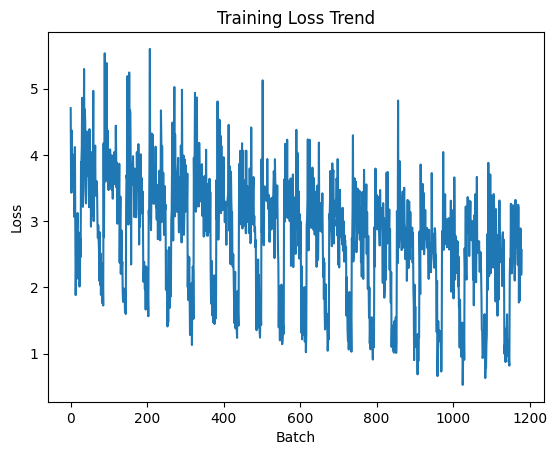

44679


In [23]:
after_add_Trained_Tokenizer = BertTokenizerFast.from_pretrained("/home/azureuser/cloudfiles/code/Users/hb.suh/OUR_BERT/trained_tokenizer/ADD1000_tokenizer_model")

model = resize_and_initialize_embeddings(model, after_add_Trained_Tokenizer )
print(len(after_add_Trained_Tokenizer))

train_dataset = dataset['train']
tokenized_datasets = tokenize_data(after_add_Trained_Tokenizer, train_dataset)
model.resize_token_embeddings(len(after_add_Trained_Tokenizer))
# 모델 학습 
model = train_model(model, tokenized_datasets, after_add_Trained_Tokenizer , 20, early_stopping_patience=5)

print(len(after_add_Trained_Tokenizer))

# 모델 저장
save_model(model, after_add_Trained_Tokenizer, "kcbert-base")

In [ ]:
# 15-16-15
# 